# NLP Project: The State of Kanye West

In [3644]:
# Main Imports
import re
import requests
import pandas as pd
import numpy as np
import json
import time
import string
import warnings

#Graphing Stuff
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#NLTK items
from nltk.corpus import stopwords

#Scraping
from bs4 import BeautifulSoup

#sklearn dohickeys
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import LatentDirichletAllocation, NMF

#gensim things
from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()


How has Kanye's changed as an artist and person and what can we learn using machine learning on bipolar?
- Topic Modeling
- NLP
- Recursive Neural Network
    - Word 2 Vec
- K-means

## 1.0 Data Collection

Will use Orion API seed to pull lyrics, first will start with a test pull

In [2647]:
## Lets load in our keys as variables below 
with open('./keys/orion_keys.txt') as f:
       orion_keys = {'api_key' : f.read().split(',')[0]}

In [2648]:
artist = "Kanye%West"

In [2649]:
song = "Gold%20Digger"

In [2650]:
url = "https://orion.apiseeds.com/api/music/lyric/" + artist + "/" + song + "?apikey=" + orion_keys['api_key']

'https://orion.apiseeds.com/api/music/lyric/Kanye%West/Gold%20Digger?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr'

In [11]:
res = requests.get(url)
res.status_code

200

_Status Code return at 200, Will check now what data looks like_

In [13]:
data = res.json() # Store data that is pulled

In [23]:
data['result']['track'].keys() # Keys in Dictionary

dict_keys(['name', 'text', 'lang'])

In [24]:
data['result']['track']['name'] # Track Name

'Gold Digger'

###  1.1 Pull Song Lyrics Function

In [36]:
# Since we will be pulling multiple songs, best to build a function to do so

In [3]:
def gold_digger(artist, song_list,exclude_list):
    after= None 
    skipped_list = []
    
    for i in range(len(song_list)):
        if song_list[i].replace(' ','%') not in exclude_list:
            url = "https://orion.apiseeds.com/api/music/lyric/" + artist + "/" + song_list[i].replace(' ','%') + "?apikey=" + orion_keys['api_key']
        else:
            pass
        
        current_track = []
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url)
        #print(res.status_code)
        if res.status_code != 200:
            print('Status error: ', res.status_code)
            skipped_list.append(song_list[i])
            pass
        else:
            current_dict = res.json()
            current_dict['result']['track'].pop('lang', None)
            current_track = []
            current_track.append(current_dict['result']['track'])

            time.sleep(5)

            if i > 0:
                current_df = pd.DataFrame(current_track)
                prev_songs = pd.read_csv(artist + '.csv')
                all_posts = pd.concat([prev_songs,current_df])
                all_posts.to_csv(artist + '.csv', index=False)
            else:
                current_df = pd.DataFrame(current_track)
                current_df.to_csv(artist + '.csv', index=False)
                all_posts = current_df
    return skipped_list

In [10]:
# Create list of songs to search over
song_list = [song]
exclude_list = []

In [13]:
# Test function
gold_digger(artist,song_list,exclude_list=exclude_list)

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Gold%20Digger?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr


[]

### 1.2 Get Kanye's Discography

In [2879]:
# Import Spotipy Library to access data about discography
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

In [3572]:
## Lets load in our keys as variables below 
with open('./keys/spotify_keys.txt') as f:
    cid, cids = f.read().split(',')

In [3573]:
spotify_keys = {"client_id": cid,
                "client_secret": cids
               }

In [3574]:
# Save Spotify Dev credential for searches
cred = SpotifyClientCredentials(client_id=spotify_keys['client_id'],client_secret=spotify_keys['client_secret'])

In [3575]:
# Instantiate Spotify wrapper with access token
sp = Spotify(auth=cred.get_access_token())

In [19]:
# Kanye's Spoitfy id
Kanye_spotify_id = '5K4W6rqBFWDnAN6FQUkS6x'
album_dict = sp.artist_albums(Kanye_spotify_id,country='US')

In [20]:
album_dict['items'][0] # Review Dictionary Structure for spotipy 

{'album_group': 'album',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2hPgGN4uhvXAxiXQBIXOmE'},
   'href': 'https://api.spotify.com/v1/artists/2hPgGN4uhvXAxiXQBIXOmE',
   'id': '2hPgGN4uhvXAxiXQBIXOmE',
   'name': 'KIDS SEE GHOSTS',
   'type': 'artist',
   'uri': 'spotify:artist:2hPgGN4uhvXAxiXQBIXOmE'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/5K4W6rqBFWDnAN6FQUkS6x'},
   'href': 'https://api.spotify.com/v1/artists/5K4W6rqBFWDnAN6FQUkS6x',
   'id': '5K4W6rqBFWDnAN6FQUkS6x',
   'name': 'Kanye West',
   'type': 'artist',
   'uri': 'spotify:artist:5K4W6rqBFWDnAN6FQUkS6x'},
  {'external_urls': {'spotify': 'https://open.spotify.com/artist/0fA0VVWsXO9YnASrzqfmYu'},
   'href': 'https://api.spotify.com/v1/artists/0fA0VVWsXO9YnASrzqfmYu',
   'id': '0fA0VVWsXO9YnASrzqfmYu',
   'name': 'Kid Cudi',
   'type': 'artist',
   'uri': 'spotify:artist:0fA0VVWsXO9YnASrzqfmYu'}],
 'external_urls': {'spotify': 'https://open.spot

In [21]:
album_dict['items'][0]['id'] # Spotify Album ID

'6pwuKxMUkNg673KETsXPUV'

In [22]:
album_dict['items'][0]['name'] # Spotify Albun Name

'KIDS SEE GHOSTS'

In [23]:
album_dict['items'][0]['release_date'] # Spotify Album Release Date

'2018-06-08'

In [24]:
album_dict['items'][0]['total_tracks'] # Tracks per album

7

In [25]:
len(album_dict['items']) # Total Albums

20

In [26]:
kanye_albums = [p for p in album_dict['items']] # Create list of Kanye's discography

In [27]:
df_albums = pd.DataFrame(kanye_albums)

In [3714]:
df_albums.head()

,album_group,album_type,artists,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri
0,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/6p...,https://api.spotify.com/v1/albums/6pwuKxMUkNg6...,6pwuKxMUkNg673KETsXPUV,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",KIDS SEE GHOSTS,2018-06-08,day,7,album,spotify:album:6pwuKxMUkNg673KETsXPUV
1,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/5E...,https://api.spotify.com/v1/albums/5EBGCvO6upi3...,5EBGCvO6upi3GNknMVe9x9,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",ye,2018-06-01,day,7,album,spotify:album:5EBGCvO6upi3GNknMVe9x9
2,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/7g...,https://api.spotify.com/v1/albums/7gsWAHLeT0w7...,7gsWAHLeT0w7es6FofOXk1,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Life Of Pablo,2016-06-10,day,20,album,spotify:album:7gsWAHLeT0w7es6FofOXk1
3,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/7D...,https://api.spotify.com/v1/albums/7D2NdGvBHIav...,7D2NdGvBHIavgLhmcwhluK,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Yeezus,2013-01-01,day,10,album,spotify:album:7D2NdGvBHIavgLhmcwhluK
4,album,album,[{'external_urls': {'spotify': 'https://open.s...,{'spotify': 'https://open.spotify.com/album/20...,https://api.spotify.com/v1/albums/20r762YmB5He...,20r762YmB5HeofjMCiPMLv,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",My Beautiful Dark Twisted Fantasy,2010-01-01,day,13,album,spotify:album:20r762YmB5HeofjMCiPMLv


In [318]:
album_list = list(df_albums.name.unique())
print(album_list)

['KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo', 'Yeezus', 'My Beautiful Dark Twisted Fantasy', '808s & Heartbreak', 'Graduation', 'Late Registration', 'The College Dropout', 'The College Dropout (Edited)', 'I Love It [(Freaky Girl) Edit]', 'I Love It', 'XTCY', 'Lift Yourself']


In [320]:
# Find out the number of albums
num_albums = len(album_list)
print(num_albums)

14


#### Some Data Organizing

In [3611]:
# Make a function to clean song name before adding to a dictionary for mapping
def lowercase_certain_words(strings,word_list):
    string_list = []
    extra_words = ['Freestyle Live From Singapore', 'Bonus Track', 'Freaky Girl Edit', 'Lil Pump']
    for char in string.punctuation:
        strings.replace(char,"")         
    for words in extra_words:
        strings.replace(words,"")
    for word in strings.split(' '):
        if word not in word_list:
            string_list.append(word)
        else:
            string_list.append(word.lower())
    strings = " ".join(string_list)
    return strings

In [3614]:
# Make dictionary for mapping data together
album_date_dict = {}
album_song_dict = {}
album_tracknum_dict = {}

for album_id in df_albums.id:
    #print(album_id)
    album_name = df_albums.loc[(df_albums.id==album_id),'name'].values[0] #map id to name to use as key in 
    
    album_tracks = []
    temp_dict = {}
    temp_dict = sp.album_tracks(album_id=album_id)
    album_tracknum_dict[album_name] = len(temp_dict['items']) #Store number of tracks on an album to a dictionary
                                          
    #print(len(temp_dict['items']))
    album_tracks = [temp_dict['items'][i]['name'] for i in range(0,len(temp_dict['items']))]
    
    for track in album_tracks:
        track = lowercase_certain_words(track,['Of','A','The','In'])
        album_song_dict[track] = album_name # store album associated with song to a dictionary

# Make a dictionary to map album to release date
for album in album_list:
    album_date_dict[album] = df_albums.loc[df_albums.name == album,'release_date'].unique()[0]


In [3651]:
album_song_dict['Freeee (Ghost Town, Pt. 2)'] = 'KIDS SEE GHOSTS'
album_song_dict['Blood On The Leaves'] = 'Yeezus'
album_song_dict['Power'] ='My Beautiful Dark Twisted Fantasy'
album_song_dict['All Of The Lights (Interlude)'] = 'My Beautiful Dark Twisted Fantasy'
album_song_dict['Who Will Survive In America'] = 'My Beautiful Dark Twisted Fantasy'
album_song_dict['The Glory'] = 'Graduation'
album_song_dict['Diamonds From Sierra Leone (Remix)'] ='Late Registration'
album_song_dict['The New Workout Plan'] = 'The College Dropout'
album_song_dict['Breathe In Breathe Out'] = 'The College Dropout'
album_song_dict['Feel The Love'] = 'KIDS SEE GHOSTS'
album_song_dict['Father Stretch My Hands Pt 1']= 'The Life Of Pablo'
album_song_dict['Pt 2']= 'The Life Of Pablo'
album_song_dict['Franks Track'] = 'The Life Of Pablo'
album_song_dict['No More Parties In LA'] ='The Life Of Pablo'
album_song_dict['Im In It'] = 'Yeezus'
album_song_dict['Pinocchio Story'] = '808s & Heartbreak'
album_song_dict['Skit 1'] = 'Late Registration'
album_song_dict['Skit 2'] = 'Late Registration'
album_song_dict['Skit 3'] = 'Late Registration'
album_song_dict['Skit 4'] = 'Late Registration'
album_song_dict['Diamonds From Sierra Leone'] = 'Late Registration'
album_song_dict['I Love It'] = 'I Love It'


#### Condense song title and album into lists for reference

In [29]:
# Create List of all songs using album ID from Spotify
album_song_list = [sp.album_tracks(album_id=album_id)['items'] for album_id in df_albums.id]

In [2912]:
album_song_list[0][0]['name']

'Feel The Love'

In [2830]:
# Clean redundant album list
album_list.remove('I Love It [(Freaky Girl) Edit]')
album_list

['KIDS SEE GHOSTS',
 'ye',
 'The Life Of Pablo',
 'Yeezus',
 'My Beautiful Dark Twisted Fantasy',
 '808s & Heartbreak',
 'Graduation',
 'Late Registration',
 'The College Dropout',
 'I Love It',
 'XTCY',
 'Lift Yourself']

In [2845]:
# Number of Songs Collected
song_list = []

for i in range(0,len(album_song_list)):
    current_song_list = [album for album in album_song_list[i]]
    song_list.extend(current_song_list)
len(song_list)
        

219

In [31]:
# Make Dataframe of songs
df_songs = pd.DataFrame(song_list)

In [2871]:
album_dict = {}
for i in range(0,len(album_song_list)): 
    for j in range(0, len(album_song_list[i])):
        album_dict[album_song_list[i][j]['name']] = album_song_list[i][j]['artists'][0]['name']

In [32]:
# Remove duplicates to create list of songs
kanye_songs = list(df_songs.loc[~df_songs.name.str.contains('(Edited)')].name.unique())

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [33]:
# Number of Unique Songs
len(kanye_songs)

128

### 1.3 Use Function to get Lyrics

In [35]:
skip_list = []
skipped_list = gold_digger(artist,kanye_songs,skip_list)

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Feel%The%Love?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Fire?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/4th%Dimension?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Freeee%(Ghost%Town%Pt.%2)?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Reborn?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Kids%See%Ghosts?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Cudi%Montage?apikey=vd9GJitiNw0S

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Say%You%Will?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Welcome%To%Heartbreak?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Heartless?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Amazing?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Love%Lockdown?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Paranoid?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/RoboCop?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/mus

https://orion.apiseeds.com/api/music/lyric/Kanye%West/Breathe%In%Breathe%Out?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit%Skit%1?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/School%Spirit%Skit%2?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
Status error:  404
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Lil%Jimmy%Skit?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Two%Words?apikey=vd9GJitiNw0S203ir7G0arPXQTR5bovqcyYLLgI6KUgLeictlH6U2HBNjacuhFjr
https://orion.apiseeds.com/api/music/lyric/Kanye%West/Through%The%Wire?apikey=vd9GJitiNw0S203ir7G0arPX

In [121]:
df_ye = pd.read_csv('./Kanye%West.csv')

####  1.3.1 Fill in Lyrics from skipped list

In [37]:
# This list were skipped during the API query, we will try to fill them in using Beautiful Soup
skipped_list

['Feel The Love',
 'Fire',
 '4th Dimension',
 'Reborn',
 'Cudi Montage',
 'Ultralight Beam',
 'Father Stretch My Hands Pt. 1',
 'Pt. 2',
 'Waves',
 'FML',
 'Real Friends',
 "Frank's Track",
 'Siiiiiiiiilver Surffffeeeeer Intermission',
 '30 Hours',
 'No More Parties In LA',
 'Hold My Liquor',
 "I'm In It",
 'Guilt Trip',
 'Send It Up',
 'Pinocchio Story (Freestyle Live From Singapore)',
 'Skit #1',
 'Skit #2',
 'Skit #3',
 'Skit #4',
 'Diamonds From Sierra Leone - Bonus Track',
 'Intro',
 'School Spirit Skit 1',
 'School Spirit Skit 2',
 'I Love It - (Freaky Girl) Edit',
 'I Love It (& Lil Pump)',
 'XTCY']

In [83]:
# Make function to scrape Genius lyrics site
def scrap_song_url(song, artist):
    song = song.replace(" ","-")
    print(song)
    url = 'https://genius.com/'+artist+'-'+song+'-lyrics'
    res = requests.get(url)
    print(url)
    if res.status_code != 200:
        artist_2 = 'kids-see-ghosts'
        url2 = 'https://genius.com/'+artist_2+'-'+song+'-lyrics'
        res = requests.get(url2)
        if res.status_code != 200:
            print('Status error: ', res.status_code)
            lyrics = ""
            pass
        else:
            html = BeautifulSoup(res.text, 'html.parser')
            lyrics = html.find('div', class_='lyrics').get_text()
    else:
        html = BeautifulSoup(res.text, 'html.parser')
        lyrics = html.find('div', class_='lyrics').get_text()

    return lyrics

In [110]:
# Clean list to be able to be used in url
for char in string.punctuation:
    skipped_list =[song.replace(char,"") for song in skipped_list]

In [116]:
# Some extra words in song name that need to be removed
extra_words = ['Freestyle Live From Singapore', 
               'Bonus Track', 
               'Freaky Girl Edit', 
               'Lil Pump'] # never thought i would code 'lil pump' but here we are....
for words in extra_words:
    skipped_list =[song.replace(words,"") for song in skipped_list]

In [117]:
skipped_list # CLEANED LIST

['Feel The Love',
 'Fire',
 '4th Dimension',
 'Reborn',
 'Cudi Montage',
 'Ultralight Beam',
 'Father Stretch My Hands Pt 1',
 'Pt 2',
 'Waves',
 'FML',
 'Real Friends',
 'Franks Track',
 'Siiiiiiiiilver Surffffeeeeer Intermission',
 '30 Hours',
 'No More Parties In LA',
 'Hold My Liquor',
 'Im In It',
 'Guilt Trip',
 'Send It Up',
 'Pinocchio Story ',
 'Skit 1',
 'Skit 2',
 'Skit 3',
 'Skit 4',
 'Diamonds From Sierra Leone  ',
 'Intro',
 'School Spirit Skit 1',
 'School Spirit Skit 2',
 'I Love It  ',
 'I Love It  ',
 'XTCY']

In [119]:
# run scrape function for Genius website
df = pd.DataFrame(columns=['name','text'])

for song in skipped_list:
    song = song.strip(" ")
    lyric = scrap_song_url(song,'Kanye-West')
    df.loc[len(df)] = {'name':song,'text': lyric}

Feel-The-Love
https://genius.com/Kanye-West-Feel-The-Love-lyrics
Fire
https://genius.com/Kanye-West-Fire-lyrics
4th-Dimension
https://genius.com/Kanye-West-4th-Dimension-lyrics
Reborn
https://genius.com/Kanye-West-Reborn-lyrics
Cudi-Montage
https://genius.com/Kanye-West-Cudi-Montage-lyrics
Ultralight-Beam
https://genius.com/Kanye-West-Ultralight-Beam-lyrics
Father-Stretch-My-Hands-Pt-1
https://genius.com/Kanye-West-Father-Stretch-My-Hands-Pt-1-lyrics
Pt-2
https://genius.com/Kanye-West-Pt-2-lyrics
Waves
https://genius.com/Kanye-West-Waves-lyrics
FML
https://genius.com/Kanye-West-FML-lyrics
Real-Friends
https://genius.com/Kanye-West-Real-Friends-lyrics
Franks-Track
https://genius.com/Kanye-West-Franks-Track-lyrics
Siiiiiiiiilver-Surffffeeeeer-Intermission
https://genius.com/Kanye-West-Siiiiiiiiilver-Surffffeeeeer-Intermission-lyrics
30-Hours
https://genius.com/Kanye-West-30-Hours-lyrics
No-More-Parties-In-LA
https://genius.com/Kanye-West-No-More-Parties-In-LA-lyrics
Hold-My-Liquor
https:

---

__ALL SONGS LYRICS ARE NOW COLLECTED__

---

In [122]:
# combine original list with skipped list after scraping
df_lyrics = pd.concat([df_ye,df])

In [1366]:
df_lyrics.reset_index(inplace=True)

In [174]:
df_lyrics.name.value_counts().head()

Gold Digger    2
I Love It      2
Runaway        1
Get Em High    1
Monster        1
Name: name, dtype: int64

In [189]:
# Remove duplicate songs and check that it worked
df_lyrics.drop_duplicates(subset='name', keep='last',inplace=True)
df_lyrics.name.value_counts().head()

Runaway                          1
Get Em High                      1
Monster                          1
All Of The Lights (Interlude)    1
Feel The Love                    1
Name: name, dtype: int64

#### Add song classifers as new columns in main DF

In [3653]:
# Map album to song in DF
df_lyrics['album'] = df_lyrics['name']
df_lyrics['album'] = df_lyrics['album'].map(album_song_dict)

In [3727]:
# Map release date to album in DF
df_lyrics['release_date'] = df_lyrics['album']
df_lyrics['release_date'] = df_lyrics['album'].map(album_date_dict)

### 1.4 Clean Word Data

In [3116]:
# assign to corpus for inital model
corpus = df_lyrics['text']

In [1887]:
df_lyrics['text'][0]

'[Intro: Marcus Garvey]\nMay I say something to you to give you\na true knowledge of yourself and life?\nMan in the full knowledge of himself\nis a superb and supreme creature of creation\nWhen man becomes possessor of the knowledge of himself, He becomes the master of his environment\n\nI don\'t feel pain anymore\nGuess what, baby? I feel free (scoop!)\nNothin\' hurts me anymore\nGuess what, baby? I feel free\n\nI\'m so complete anymore\nGuess what, baby? I feel free\nAnd you know damn well\nHe lift me up every time that I fell\nAnd set me free, yeah\nAh! You should quit your job to this\nHold up, that\'ll politic, ooh\nOne day they hate you\nNext day they love you\nI\'m still yellin\' "fuck you"\nI could never trust—\n\nFree, I feel free\nI feel free, I feel free\n\nI don\'t feel pain anymore\nGuess what, babe? I am free\nYeah, nothin\' hurts me anymore\nGuess what, babe? I am free\n\nYeah, yeah, yeah, yeah\nFeelin\' out of my past life\nDied and came back twice\nNow I\'m free\n\nI d

#### 1.4.1 Remove song attributes

In [1889]:
# Some lyrics have text describing which versus or chorus or singer surrounded by [], this regex replaces those with blanks
df_lyrics['text'] = [re.sub(r"\[[^\]]*\]", '',lyrics) for lyrics in df_lyrics['text']]

#### 1.4.2 Add Song Length

In [3119]:
song_length = []
for song in range(0,len(corpus)):
    text = corpus[song]

    for char in '-.,\n':
        text=text.replace(char,' ')
    text = text.lower()
    # split returns a list of words delimited by sequences of whitespace (including tabs, newlines, etc, like re's \s) 
    word_list = text.split()

    song_length.append(len(word_list))

In [3121]:
df_lyrics["song_length"] = song_length
df_lyrics.head()

,level_0,index,name,text,topic,lyrics_lemmatized,song_length
0,1,1,"Freeee (Ghost Town, Pt. 2)",\nMay I say something to you to give you\na tr...,3,may i say something to you to give you a true ...,204
1,2,2,Kids See Ghosts,Kids see ghosts sometimes\nKids see ghosts som...,0,kid see ghost sometimes kid see ghost sometime...,469
2,3,3,I Thought About Killing You,"I know, I know, I know, I know, know\nI know, ...",0,"i know, i know, i know, i know, know i know, i...",584
3,4,4,Yikes,"Shit could get menacin', frightenin', find hel...",0,"shit could get menacin', frightenin', find hel...",443
4,5,5,All Mine,"Yeah, you supermodel thick, damn\nThat ass bus...",4,"yeah, you supermodel thick, damn that as busti...",400


In [3929]:
df_lyrics.song_length.sum()

62648

#### Review text structure in DataFrame

In [3208]:
# Review the corpus of one particular song
df_lyrics[df_lyrics['name'] == 'Lift Yourself']

,level_0,index,name,text,topic,lyrics_lemmatized,song_length,TEXTlyrics_lemmatized
96,97,97,Lift Yourself,"Hard to see, ooh\nThe hang ups we have today-a...",0,"hard to see, ooh the hang ups we have today-ay...",287,"hard to see, ooh the hang ups we have today-ay..."


In [3209]:
print(corpus[97])




I can still feel the love
I can still feel the love
I can still feel the love
Feel the love


We not worried 'bout no other niggas, we them other niggas
You bust down a Rollie, I bust down a brick, then I flood it, nigga
I am not to be compared to you rappers, Eazy-Duz-It, nigga
I am more Eazy, you tryin’ your best to become me, nigga
She like them bottles with bubbles in it
Buy her Loewe and other linen
Why would I wait when there's other women?
Why would I hate? We in love with winnin' (ooh!)
Buy her bundles, fly her out, bring her friend, I try her out
Ain’t no worries findin' out, the details is ironed out
Easily they plays along, hopin' that I play a song
Love to fuck to trap music (feel the love)
Grrrat-gat-gat-gat-gat
Dope money just came along (woo)


Grrrat-gat (I can still feel the love)
Gat-gat, gat, ga-ga-ga-ga-gat
Grrrat, gat-gat-gat (I can still feel the love)
Gat-gat-gat-gat-gat-gat-gat, grrrat
Gat-gat-gat-gat (feel the love)
Ga-ga-gat, ga-gat, ga-gat, ga-gat-gat, grr

### 1.4.1 Clean Data Function

In [3027]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [3222]:
# (10/17) Review Data Structure 
df_lyrics['text'][0]

'\nMay I say something to you to give you\na true knowledge of yourself and life?\nMan in the full knowledge of himself\nis a superb and supreme creature of creation\nWhen man becomes possessor of the knowledge of himself, He becomes the master of his environment\n\nI don\'t feel pain anymore\nGuess what, baby? I feel free (scoop!)\nNothin\' hurts me anymore\nGuess what, baby? I feel free\n\nI\'m so complete anymore\nGuess what, baby? I feel free\nAnd you know damn well\nHe lift me up every time that I fell\nAnd set me free, yeah\nAh! You should quit your job to this\nHold up, that\'ll politic, ooh\nOne day they hate you\nNext day they love you\nI\'m still yellin\' "fuck you"\nI could never trust—\n\nFree, I feel free\nI feel free, I feel free\n\nI don\'t feel pain anymore\nGuess what, babe? I am free\nYeah, nothin\' hurts me anymore\nGuess what, babe? I am free\n\nYeah, yeah, yeah, yeah\nFeelin\' out of my past life\nDied and came back twice\nNow I\'m free\n\nI don\'t feel pain anymor

In [3232]:
# (10/17) Step 1: Split Lines
clean_text_step1 = [song.splitlines() for song in df_lyrics['text']]

In [3797]:
s ='Guess what, baby? I feel free (scoop!)'
#s = re.sub(r'[^\w\s]','',s)
#s

In [3804]:
[word for word in s.lower().split() if word not in stop]

['guess', 'what,', 'baby?', 'feel', 'free', '(scoop!)']

In [3805]:
# (10/17) Step 2: Remove punctuation and then empty elements from list
clean_text_step2 = []

for song in clean_text_step1:
    clean_song = []
    for line in song:
        if  line != '':
            line = re.sub(r'[^\w\s]','',line) # Removes Punctuation
            #s = ' ' # set spacing for join
            #line2 = s.join([lemmatizer.lemmatize(word.lower()) for word in line.split() if word not in stop]) # Stem words (remove plural)
            line2 = [lemmatizer.lemmatize(word) for word in line.lower().split() if word not in stop]
            print(line2)
            #line3 = []
            #line3.append([word for word in line2.split(' ') if word not in stop])
            clean_song.append(line2)
        else:
            pass
    clean_text_step2.append(clean_song)
    
    #[text_corpus_2.append([word for word in sentence.split(' ') if word not in stop]) for sentence in by_sentence]
    
    #clean_text_step3 = s.join([lemmatizer.lemmatize(word.lower()) for line in clean_text_step2])

['may', 'say', 'something', 'give']
['true', 'knowledge', 'life']
['man', 'full', 'knowledge']
['superb', 'supreme', 'creature', 'creation']
['man', 'becomes', 'possessor', 'knowledge', 'becomes', 'master', 'environment']
['dont', 'feel', 'pain', 'anymore']
['guess', 'baby', 'feel', 'free', 'scoop']
['nothin', 'hurt', 'anymore']
['guess', 'baby', 'feel', 'free']
['im', 'complete', 'anymore']
['guess', 'baby', 'feel', 'free']
['know', 'damn', 'well']
['lift', 'every', 'time', 'fell']
['set', 'free']
['quit', 'job']
['hold', 'thatll', 'politic']
['one', 'day', 'hate']
['next', 'day', 'love']
['im', 'still', 'yellin', 'fuck']
['never', 'trust']
['free', 'feel', 'free']
['feel', 'free', 'feel', 'free']
['dont', 'feel', 'pain', 'anymore']
['guess', 'babe', 'free']
['nothin', 'hurt', 'anymore']
['guess', 'babe', 'free']
[]
['feelin', 'past', 'life']
['died', 'came', 'back', 'twice']
['im', 'free']
['dont', 'feel', 'pain', 'anymore']
['guess', 'babe', 'free']
['feel', 'free', 'feel', 'free']


['throwing', 'hate']
['want', 'stay', 'ease']
['fuck', 'corporation']
['yall', 'nigga', 'cant', 'control']
['know', 'new', 'slave']
['know', 'new', 'slave']
['im', 'wild', 'fuck']
['im', 'going', 'bobby', 'boucher']
['know', 'pussy', 'aint', 'free']
['nigga', 'pussy', 'aint']
['yall', 'throwing', 'contract']
['know', 'nigga', 'cant', 'read']
['throw', 'maybach', 'key']
['fuck', 'cest', 'vie']
['know', 'new', 'slave']
['yall', 'nigga', 'cant', 'fuck']
['yall', 'nigga', 'cant', 'fuck', 'ye']
['yall', 'nigga', 'cant', 'fuck', 'ye']
['ill', 'move', 'family', 'country']
['cant', 'stay']
['grab', 'reporter']
['smash', 'recorder']
['theyll', 'confuse', 'u']
['bullshit', 'new', 'world', 'order']
['meanwhile', 'dea']
['teamed', 'cca']
['tryna', 'lock', 'nigga']
['tryna', 'make', 'new', 'slave']
['thats', 'private', 'owned', 'prison']
['piece', 'today']
['probably', 'hampton']
['braggin', 'bout', 'maid']
['fuck', 'hampton', 'house']
['ill', 'fuck', 'hampton', 'spouse']
['came', 'hampton', 'blous

['no', 'drug', 'pussy', 'religion', 'need']
['grab', 'hand', 'baby', 'well', 'live', 'hell', 'life']
['never', 'wildest', 'dream']
['never', 'wildest', 'dream', 'wildest']
['hear', 'loudest', 'scream']
['comin', 'inside', 'screen', 'wild', 'bitch']
['tell', 'guy']
['said', 'price', 'ever', 'fuck', 'black', 'guy']
['anal', 'gangbang']
['kinda', 'crazy', 'thats', 'considered', 'thing']
['well', 'guess', 'lotta', 'nigga', 'gang', 'bang']
['run', 'train', 'gang']
['runaway', 'slave', 'chain', 'gang']
['bang', 'bang', 'bang', 'bang', 'bang']
['lost', 'mind']
['tell', 'think', 'crossed', 'line']
['no', 'drug', 'pussy', 'religion', 'need']
['grab', 'hand', 'baby', 'well', 'live', 'hell', 'life']
['one', 'day', 'im', 'gon', 'marry', 'porn', 'star']
['well', 'bigass', 'crib', 'long', 'yard']
['well', 'mansion', 'fly', 'maid']
['nothin', 'hide', 'screwed', 'bridesmaid']
['wanna', 'role', 'play', 'til', 'roll']
['imma', 'need', 'whole', 'day', 'least', 'rolled', 'doja']
['party', 'goin', 'oscar',

['stronger', 'harder', 'better', 'faster', 'stronger']
['never']
['work', 'harder', 'make', 'better', 'faster', 'make', 'u']
['stronger', 'harder', 'better', 'faster', 'stronger']
['never']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['ive', 'waiting', 'whole', 'life']
['dream', 'waking', 'night']
['say', 'think', 'im', 'never', 'wrong']
['know', 'maybe', 'youre', 'right', 'aight']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['say', 'fucking', 'nerve']
['hope', 'deserves', 'word']
['even', 'remember', 'issue']
['trying', 'find', 'tissue']
['still', 'wish']
['aint', 'happen', 'yet']
['thats', 'intuition']
['hop', 'back', 'car']
['drive', 'back', 'crib']
['run', 'back', 'arm']
['smokescreen']
['choke', 'scream']
['ever', 'wonder', 'really', 'mean']
['wonder', 'know']
['mean', 'mean']
['wonder', 'know']
['mean', 'find', 'dream']
['im', 'back', 'grind']
['psychic', 'read', 'lifeline']
['told', 'lifetime']
['name', 'w

['child', 'unheld']
['wish', 'love', 'sale', 'behold', 'pale', 'horse']
['trapped', 'r', 'kel', 'bail']
['might', 'not', 'bad', 'idea', 'never']
['never', 'went', 'home']
['im', 'way', 'home']
['left', 'three', 'day', 'ago', 'no', 'one', 'seems', 'know', 'im', 'gone']
['home', 'hatred', 'home', 'filled', 'pain']
['might', 'not', 'bad', 'idea', 'never']
['never', 'went', 'home']
['thats', 'crack', 'music', 'nigga']
['real', 'black', 'music', 'nigga']
[]
['thats', 'crack', 'music', 'nigga']
['real', 'black', 'music', 'nigga']
[]
['stop', 'black', 'panther']
['ronald', 'reagan', 'cooked', 'answer']
['hear', 'gil', 'scott', 'hearin']
['hero', 'heroine', 'hooked', 'heroin']
['crack', 'raised', 'murder', 'rate', 'dc', 'maryland']
['invested', 'merrill', 'lynched']
['hangin', 'tree', 'ever', 'since']
['sometimes', 'feel', 'music', 'medicine']
['cook', 'cut', 'measure', 'bag']
['sell', 'fiend', 'cop', 'nowadays', 'cant', 'tell']
['thats', 'good', 'shit', 'aint', 'sure', 'man']
['put', 'cd', 't

['im', 'trying', 'find', 'peace']
['shouldve', 'finished', 'school', 'niece']
['finally', 'wouldnt', 'use', 'piece', 'blaw']
['ive', 'workin', 'graveshift', 'aint', 'made', 'shit']
['wish', 'buy', 'spaceship', 'fly', 'past', 'sky']
['ive', 'workin', 'graveshift', 'aint', 'made', 'shit']
['wish', 'buy', 'spaceship', 'fly', 'past', 'sky']
['remember', 'take', 'dollar', 'cab']
['coming', 'home', 'real', 'late', 'night']
['standing', 'foot', 'damn', 'day']
['trying', 'make', 'thing', 'right']
['one', 'coworkers', 'say', 'yo', 'look']
['kid', 'seen', 'old', 'busta', 'rhyme', 'video', 'night']
['well', 'easy', 'come', 'easy', 'saying', 'go']
['no', 'broad', 'service', 'car', 'tv', 'show']
['snatched']
['ar', 'faculty', 'turn', 'back']
['didnt', 'want', 'hear', 'rap']
['naturally', 'actually', 'face', 'thing', 'factually']
['catastrophe', 'fridge', 'staring', 'back']
['cause', 'nothing', 'nothing', 'fair']
['dont', 'want', 'ever', 'back']
['wont', 'taking', 'no', 'day', 'til', 'spaceship', 't

['thing', 'thing']
['thing', 'thing']
['thing', 'thing']
['mommy', 'daddy', 'please', 'stop', 'fighting']
['thing', 'thing']
['thing', 'dont', 'care', 'thing']
['thing', 'thing']
['thing', 'thing']
['let', 'stevie', 'outta', 'jail']
['yo', 'fuck', 'kanye', 'first', 'foremost']
['making', 'shit', 'muhfucker']
['throw', 'everybody', 'motherfucking', 'room']
['cause', 'dont', 'fucking']
['id', 'propose', 'toast']
['said', 'toast', 'motherfucker']
[]
['here', 'roc']
['ask', 'ask', 'ask', 'tell']
['here', 'rocafella']
['raise', 'glass', 'glass', 'glass', 'sky']
['here', 'roc']
['last', 'call', 'alcohol']
['mr', 'rockefeller']
['as', 'wall']
['around', 'world', 'digital', 'underground', 'pac']
['rudolph', 'rednosed', 'reindeer', 'roc']
['take', 'chain', '15', 'second', 'fame']
['come', 'back', 'next', 'year', 'whole', 'fucking', 'game']
['aint', 'nobody', 'expect', 'kanye', 'end', 'top']
['expected', 'college', 'dropout', 'drop', 'flop']
['maybe', 'stop', 'savin', 'good', 'beat']
['rocafella

['30', 'hour']
['mothafucka', 'rock']
['brother', 'yasiin', 'holding', 'africa']
['30', 'hour']
['family', 'thank', 'holding']
['medium', 'acting']
['30', 'hour']
['thats', 'gabe', 'calling']
['yo', 'gabe']
['im', 'im', 'adlib', 'track', 'right']
['whats']
['30', 'hour']
['30', 'hour']
['ladidadaa', 'daa', 'flavor']
['ladadadadidadaa', 'laa', 'laa', 'laa', 'laa']
['tell', 'im']
['far', 'away', 'place']
['chance', 'star']
['nowhere', 'seems', 'far']
['no', 'party']
['please', 'baby', 'no', 'party']
['no', 'party']
['please', 'baby', 'no', 'party']
['no']
['los', 'angeles']
['please', 'shake', 'body', 'party', 'bod']
['please', 'shake', 'body', 'party', 'body']
['please', 'shake', 'body', 'party', 'body']
['baby', 'forgot', 'ray', 'ban']
['sheet', 'still', 'orange', 'spray', 'tan']
['soft', 'porn', 'kman']
['remember', 'sprinter', 'said', 'grape', 'van']
['uhmwell', 'cutiei', 'bougie', 'booty']
['come', 'erykahbadumewell', 'let', 'make', 'movie']
['hell', 'know', 'repertoire', 'wrestler'

In [3806]:
def clean_text(song):
    clean_text_step1 = [song.splitlines()]

    # (10/17) Step 2: Remove punctuation and then empty elements from list

    for song in clean_text_step1:
        clean_song = []
        for line in song:
            if  line != '':
                line = re.sub(r'[^\w\s]','',line) # Removes Punctuation
                #s = ' ' # set spacing for join
                #line2 = s.join([lemmatizer.lemmatize(word.lower()) for word in line.split() if word not in stop]) # Stem words (remove plural)
                line2 = [lemmatizer.lemmatize(word) for word in line.lower().split() if word not in stop]
                #line3 = []
                #line3.append([word for word in line2.split(' ') if word not in stop])
                clean_song.append(line2)
            else:
                pass
    return clean_song

In [3807]:
# Check how well the cleaning is goin' @ Removing punctuation and plural(s)
clean_text_step2[0]

[['may', 'say', 'something', 'give'],
 ['true', 'knowledge', 'life'],
 ['man', 'full', 'knowledge'],
 ['superb', 'supreme', 'creature', 'creation'],
 ['man',
  'becomes',
  'possessor',
  'knowledge',
  'becomes',
  'master',
  'environment'],
 ['dont', 'feel', 'pain', 'anymore'],
 ['guess', 'baby', 'feel', 'free', 'scoop'],
 ['nothin', 'hurt', 'anymore'],
 ['guess', 'baby', 'feel', 'free'],
 ['im', 'complete', 'anymore'],
 ['guess', 'baby', 'feel', 'free'],
 ['know', 'damn', 'well'],
 ['lift', 'every', 'time', 'fell'],
 ['set', 'free'],
 ['quit', 'job'],
 ['hold', 'thatll', 'politic'],
 ['one', 'day', 'hate'],
 ['next', 'day', 'love'],
 ['im', 'still', 'yellin', 'fuck'],
 ['never', 'trust'],
 ['free', 'feel', 'free'],
 ['feel', 'free', 'feel', 'free'],
 ['dont', 'feel', 'pain', 'anymore'],
 ['guess', 'babe', 'free'],
 ['nothin', 'hurt', 'anymore'],
 ['guess', 'babe', 'free'],
 [],
 ['feelin', 'past', 'life'],
 ['died', 'came', 'back', 'twice'],
 ['im', 'free'],
 ['dont', 'feel', 'pain

In [3192]:
#def clean_text(text):
#    s = ' ' # set spacing for join
#    return s.join([lemmatizer.lemmatize(word.lower()) for word in text.split()])
    

In [3928]:
df_lyrics['lyrics_word2vec'] = df_lyrics.text.apply(clean_text)
df_lyrics.head()

,name,text,topic,lyrics_lemmatized,song_length,text_clean,lyrics_word2vec,album,release_date
0,"Freeee (Ghost Town, Pt. 2)",\nMay I say something to you to give you\na tr...,2,may i say something to you to give you a true ...,204,"[, May I say something to you to give you, a t...","[[say], [true, knowledge, life], [man, knowled...",KIDS SEE GHOSTS,2018-06-08
1,Kids See Ghosts,Kids see ghosts sometimes\nKids see ghosts som...,0,kid see ghost sometimes kid see ghost sometime...,469,"[Kids see ghosts sometimes, Kids see ghosts so...","[[kid, ghost], [kid, ghost], [kid, ghost], [sp...",KIDS SEE GHOSTS,2018-06-08
2,I Thought About Killing You,"I know, I know, I know, I know, know\nI know, ...",5,"i know, i know, i know, i know, know i know, i...",584,"[I know, I know, I know, I know, know, I know,...","[[know, know, know, know, know], [know, know, ...",ye,2018-06-01
3,Yikes,"Shit could get menacin', frightenin', find hel...",2,"shit could get menacin', frightenin', find hel...",443,"[Shit could get menacin', frightenin', find he...","[[shit, menacin, frightenin, help], [scare, my...",ye,2018-06-01
4,All Mine,"Yeah, you supermodel thick, damn\nThat ass bus...",4,"yeah, you supermodel thick, damn that as busti...",400,"[Yeah, you supermodel thick, damn, That ass bu...","[[supermodel, damn], [as, bustin], [ima, lose,...",ye,2018-06-01


In [3828]:
df_lyrics.iloc[5,:]['lyrics_word2vec']

[['dont', 'feel', 'shes'],
 ['god', 'feel', 'windin'],
 ['butterfly', 'wrist', 'make', 'run', 'skin'],
 ['dont', 'feel'],
 ['know', 'wouldnt', 'leave'],
 ['say', 'build', 'owni', 'said', 'sway'],
 ['said', 'slavery', 'choicethey', 'said', 'ye'],
 ['just', 'imagine', 'caught', 'wild', 'day'],
 ['im', 'blog', 'gettin', 'call'],
 ['wife', 'callin', 'screamin', 'say', 'bout', 'lose'],
 ['calm', 'cause', 'breathe'],
 ['told', 'leave', 'wouldnt', 'leave'],
 ['know', 'wouldnt', 'leave'],
 ['somethin', 'free'],
 ['doin', 'thing'],
 ['wait', 'longer'],
 ['yes', 'know', 'youre'],
 ['run', 'chopped'],
 ['sundress'],
 ['know', 'wouldnt', 'leave'],
 ['dont', 'bring', 'thats', 'gon', 'sentimental'],
 ['know', 'im', 'sensitive', 'gentle', 'mental'],
 ['time', 'somethin', 'happen', 'want', 'sent', 'mental'],
 ['incident', 'cover', 'incidental'],
 ['want', 'workin', 'messagin'],
 ['im', 'thinkin', 'george', 'jetson'],
 ['soundin', 'george', 'jefferson'],
 ['questionin', 'method'],
 ['tweakin', 'text'],

In [3844]:
text_corpus_w2v = []
for song in df_lyrics.sort_values('release_date').lyrics_word2vec:
    for line in song:
        text_corpus_w2v.append(line)

In [3845]:
text_corpus_w2v[0]

['ive', 'workin', 'graveshift', 'aint', 'shit']

### 1.5 Vectorize Text Data

In [3822]:
# Edit stop list cell
stop = []
# Start off with basic stop words
#stop = list(stopwords.words('english')) # NLTK with 138
stop = list(stop_words.ENGLISH_STOP_WORDS) #sklearn with 318
# Add some additional ones I noticed
stop.extend(['could','get', 'got','gotta','like', 'ya', 'ha','don','ain','that\'s', 'll', 've', 'let', 'see','go'])
# Add misspelled 
stop.extend(['wa',])
# Add stop words for song filler phrases
stop.extend(['da','la','lah','uh','yeah','oh','ooh', 'mm','mmm', 'mhm','mhmm','ay', 'ayy','hey','whoa','hmm','huh','whoa','woah','ah', 'ohh','uhhuh'])
# Add stop words for musical notations
stop.extend(['intro','outro', 'hook','partial', 'bridge','verse','produced','instrumental','chorus', 'skit'])
# Add unique Song phrases
stop.extend(['phi', 'gwaan','bam','dem'])
# Remove from stop words relevant phrases
add_back = ['no','not','myself']
[stop.remove(word) for word in add_back];

#### 1.5.1 Count Vectorizer

In [3856]:
cvec = CountVectorizer(min_df=5,
                       max_df=0.95,
                       stop_words=stop,
                       ngram_range=(1,1),
                      )
count = cvec.fit_transform(corpus_lem);

In [3488]:
len(cvec.get_feature_names())

730

In [3489]:
df_cvec  = pd.DataFrame(cvec.transform(corpus_lem).todense(),
                   columns=cvec.get_feature_names(),
                   index=df_lyrics['name'])

In [3490]:
df_cvec.loc['Black Skinhead',df_cvec.loc['Black Skinhead'] >0].sort_values(ascending=False).head(10)

god         11
shit         9
know         6
black        5
morning      4
knew         4
nigga        4
bitch        3
moment       3
finished     3
Name: Black Skinhead, dtype: int64

In [3491]:
df_cvec.sum().sort_values(ascending=False).head(10)

know     445
no       345
nigga    259
love     224
say      218
feel     195
shit     193
need     174
man      173
make     168
dtype: int64

#### 1.5.2 TF-IDF Vectorizer

In [3492]:
tvec = TfidfVectorizer(min_df=5,
                       max_df=0.85,
                       stop_words=stop,
                       ngram_range=(1,3),
                      )
tfidf = tvec.fit_transform(corpus_lem);

In [3493]:
len(tvec.get_feature_names())

773

In [3494]:
df_tvec  = pd.DataFrame(tvec.transform(corpus_lem).todense(),
                   columns=tvec.get_feature_names(),
                   index=df_lyrics['name'])

In [3495]:
df_tvec.sum().sort_values(ascending=False).head(20)

know     8.513830
no       6.620611
love     5.651998
nigga    5.633856
say      4.954252
feel     4.849541
shit     4.605147
not      4.260562
never    4.239072
need     4.204632
man      4.141649
keep     3.982019
right    3.892137
good     3.857261
god      3.814952
one      3.728824
make     3.696015
life     3.685787
baby     3.490701
still    3.473539
dtype: float64

In [3496]:
# Export List for Tableau
df_tvec.sum().sort_values(ascending=False).head(100).to_csv('tvec top 100.csv')

In [3497]:
# Inspect Top Words of one song
df_tvec.loc['Black Skinhead',df_tvec.loc['Black Skinhead'] >0].sort_values(ascending=False).head(10)

god         0.397968
shit        0.265115
morning     0.233751
black       0.226195
knew        0.212762
bitches     0.198254
ready       0.198254
finished    0.185498
moment      0.180151
living      0.175313
Name: Black Skinhead, dtype: float64

## 2.0 Models

### 2.1 Topic Modeling

In [3900]:
# Set global parameters
n_top_words = 10 # Set number

cvec_feature_names = cvec.get_feature_names()
tfidf_feature_names = tvec.get_feature_names()

In [3499]:
# Function to print outputs of models consistently
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "   ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

#### 2.1.1 Latent Dirichlet Allocation

In [3500]:
#instantiate
lda = LatentDirichletAllocation(3, random_state=42, max_iter=50).fit(count);

In [3722]:
print("\nTopics in LDA model (count):")
print_top_words(lda, cvec_feature_names, n_top_words)


Topics in LDA model (count):
Topic #0: no   feel   keep   know   ever   still   back   thing   never   man
Topic #1: know   nigga   love   shit   no   say   need   one   girl   time
Topic #2: no   never   make   say   man   broke   right   everything   work   not



In [3502]:
# Instantiate
lda_2 = LatentDirichletAllocation(2, random_state=42, max_iter=50).fit(tfidf);

In [3723]:
print("\nTopics in LDA model (TFIDF):")
print_top_words(lda_2, tfidf_feature_names, n_top_words)


Topics in LDA model (TFIDF):
Topic #0: know   no   love   nigga   say   feel   shit   not   never   need
Topic #1: found   ring   broke   mixed   dark   cool   kanye   light   no   life



### 2.1.2 NMF

In [3901]:
nmf_c = NMF(n_components=7, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.01,
          l1_ratio=.5).fit(count)

print("\nTopics in NMF model (count):")

print_top_words(nmf_c, cvec_feature_names, n_top_words)


Topics in NMF model (count):
Topic #0: know   just   no   not   nigga   tell   cause   say   shit   wanna
Topic #1: love   no   way   feel   lord   god   shine   not   step   jesus
Topic #2: right   need   make   girl   homie   told   baby   work   better   want
Topic #3: feel   forever   day   man   free   yo   beat   won   try   deep
Topic #4: no   say   broke   man   money   kanye   real   kid   brother   head
Topic #5: good   baby   life   hand   ma   time   high   night   thing   morning
Topic #6: nigga   fuck   shit   love   yeezy   bitch   black   need   music   game



In [3902]:
nmf_t = NMF(n_components=7, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.01,
          l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model (tfidf):")

print_top_words(nmf_t, tfidf_feature_names, n_top_words)


Topics in NMF model (tfidf):
Topic #0: know   cause   no   make   tell   say   god   right   never   one
Topic #1: clothes   look   okay   school   kids   money   man   broke   pocket   making
Topic #2: feel   talk   one   love   soul   day   take   wanna   free   think
Topic #3: wake   good   people   heard   pack   sky   cop   shit   throw   feel
Topic #4: fuck   need   bitch   nigga   still   type   store   love   shit   wanna
Topic #5: know   not   keep   time   life   light   hate   street   morning   hit
Topic #6: though   remember   night   thought   back   baby   away   tried   shit   thing



#### Map categories to new column in df

In [3654]:
topics = {0:"0",
          1:"Money/Status",
          2:"Feeling"
         }

In [3903]:
W = nmf_t.fit_transform(tfidf)
H = nmf_t.components_

In [3904]:
H.shape

(7, 773)

In [3905]:
topic_map = pd.DataFrame(W)

In [3906]:
# Credit to Steve for getting inside the array
topic_per_song = [topic_map.loc[:,topic_map.iloc[song] == max(topic_map.iloc[song])].columns.values[0] for song in topic_map.index]

In [3907]:
df_lyrics['topic'] = topic_per_song
df_lyrics.replace({"topic": topics});

In [3908]:
df_lyrics.sort_values('release_date').head()

,name,text,topic,lyrics_lemmatized,song_length,text_clean,lyrics_word2vec,album,release_date
82,Spaceship,\n\n\nI've been workin' this graveshift and I ...,1,i've been workin' this graveshift and i ain't ...,771,"[, , , I've been workin' this graveshift and I...","[[ive, workin, graveshift, aint, shit], [wish,...",The College Dropout,2004-02-13
78,We Don't Care,"\n\n\nOh yeah, I've got the perfect song for t...",3,"oh yeah, i've got the perfect song for the kid...",633,"[, , , Oh yeah, I've got the perfect song for ...","[[ive, perfect, song, kid, sing], [people, tha...",The College Dropout,2004-02-13
79,Graduation Day,What in the fuck was that Kanye\nI told you to...,3,what in the fuck wa that kanye i told you to d...,190,"[What in the fuck was that Kanye, I told you t...","[[fuck, kanye], [told, shit, kid], [muthafucki...",The College Dropout,2004-02-13
80,All Falls Down,"\nOh, when it all, it all falls down\nYeah, th...",0,"oh, when it all, it all fall down yeah, this t...",739,"[, Oh, when it all, it all falls down, Yeah, t...","[[fall], [real, baby], [im, tellin, fall], [ch...",The College Dropout,2004-02-13
81,I'll Fly Away,One glad morning when this life is over\r\nI'l...,5,one glad morning when this life is over i'll f...,42,"[One glad morning when this life is over, I'll...","[[glad, morning, life], [ill, fly, away], [lan...",The College Dropout,2004-02-13


In [3926]:
df_lyrics.groupby('album').topic.value_counts()

album                              topic
808s & Heartbreak                  0        4
                                   2        3
                                   6        3
                                   5        2
Graduation                         0        6
                                   1        2
                                   3        2
                                   6        2
                                   5        1
I Love It                          4        1
KIDS SEE GHOSTS                    5        3
                                   0        2
                                   2        2
Late Registration                  1        8
                                   0        6
                                   3        3
                                   2        2
                                   6        2
Lift Yourself                      6        1
My Beautiful Dark Twisted Fantasy  0        5
                                   6   

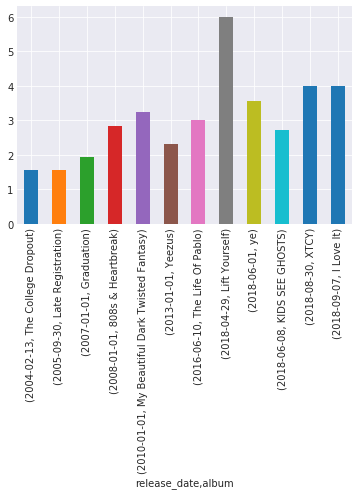

In [3920]:
df_lyrics.sort_values('release_date').groupby(['release_date','album']).topic.mean().plot(kind='bar', stacked=True)


### LDA using gensim

In [3507]:
from gensim.models.coherencemodel import CoherenceModel

In [3910]:

lyrics_text = [df_cvec.columns[df_cvec.loc[index,:].nonzero()] for index in df_cvec.index]
dictionary = corpora.Dictionary(lyrics_text)

corpus_plot = [dictionary.doc2bow(text) for text in lyrics_text]

ldamodel = models.ldamodel.LdaModel(corpus_plot,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 7,             # number of topics T to find
                                    passes = 5,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold

##### Coherence for topic modeling

In [3911]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=ldamodel, texts=lyrics_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3188529144476702


In [3912]:
def coherence_search(dictionary, corpus_dict, text, upper_limit, start=2, step=1):
    coherence_score = []
    model_list = []
    for num_topics in range(start, upper_limit, step):
        fun_model=models.ldamodel.LdaModel(corpus=corpus_dict, 
                           id2word=dictionary, 
                           num_topics=num_topics,
                           passes = 5,
                           minimum_probability = 0.01)
        model_list.append(fun_model)
        coherencemodel = CoherenceModel(model=fun_model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_score.append(coherencemodel.get_coherence())

    return model_list, coherence_score

In [3913]:
models_LDA, c_scores = coherence_search(dictionary,corpus_plot,lyrics_text,20)

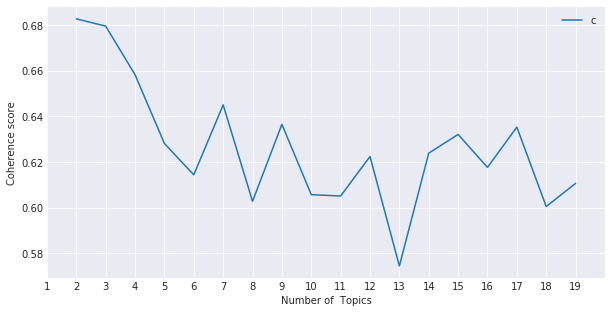

In [3435]:
x = range(2,20, 1)
plt.figure(figsize=(10,5))
plt.plot(x, c_scores)
plt.xlim(1,20)
plt.xticks(np.arange(1, 20, step=1))
plt.xlabel("Number of  Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_score"), loc='best')
plt.show()

Best number of topics 2,3,4,7

In [3914]:
pyLDAvis.gensim.prepare(models_LDA[5], corpus_plot, dictionary)

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003432 -0.003888       1        1  64.797531
5     -0.020642  0.000025       2        1  10.272178
1      0.035587  0.048541       3        1   6.553216
2     -0.007234  0.020425       4        1   6.461515
6      0.072037 -0.064938       5        1   5.027769
3     -0.006042  0.043593       6        1   3.969845
4     -0.077138 -0.043759       7        1   2.917946, topic_info=     Category       Freq     Term      Total  loglift  logprob
term                                                          
20    Default  85.000000     know  85.000000  30.0000  30.0000
84    Default  57.000000      not  57.000000  29.0000  29.0000
31    Default  70.000000      say  70.000000  28.0000  28.0000
83    Default  83.000000       no  83.000000  27.0000  27.0000
147   Default  64.000000    nigga  64.000000  26.0000  26.0000
93    Default  56.000000     shit  56.000000  25.0000  25.0000
22    Default  56.000000     love  56.000000  24.0000  24.0000
77    Default  62.000000     make  62.000000  23.0000  23.0000
50    Default  65.000000    cause  65.000000  22.0000  22.0000
12    Default  37.000000     fuck  37.000000  21.0000  21.0000
34    Default  55.000000    still  55.000000  20.0000  20.0000
235   Default  46.000000     want  46.000000  19.0000  19.0000
23    Default  51.000000      man  51.000000  18.0000  18.0000
61    Default  45.000000      gon  45.000000  17.0000  17.0000
170   Default  44.000000      way  44.000000  16.0000  16.0000
8     Default  47.000000     feel  47.000000  15.0000  15.0000
256   Default  30.000000    money  30.000000  14.0000  14.0000
279   Default  20.000000   school  20.000000  13.0000  13.0000
192   Default  53.000000    right  53.000000  12.0000  12.0000
35    Default  60.000000     time  60.000000  11.0000  11.0000
2     Default  65.000000     back  65.000000  10.0000  10.0000
21    Default  53.000000     life  53.000000   9.0000   9.0000
430   Default  30.000000    would  30.000000   8.0000   8.0000
282   Default  48.000000     tell  48.000000   7.0000   7.0000
75    Default  47.000000     look  47.000000   6.0000   6.0000
103   Default  39.000000    thing  39.000000   5.0000   5.0000
174   Default  40.000000    bitch  40.000000   4.0000   4.0000
5     Default  41.000000      day  41.000000   3.0000   3.0000
247   Default  37.000000      god  37.000000   2.0000   2.0000
28    Default  66.000000      one  66.000000   1.0000   1.0000
...       ...        ...      ...        ...      ...      ...
256    Topic7   3.007014    money  30.318462   1.2235  -4.5623
358    Topic7   1.235151     hood  10.871321   1.3594  -5.4521
373    Topic7   1.403795   street  13.261426   1.2886  -5.3241
84     Topic7   3.784118      not  57.601357   0.8116  -4.3325
434    Topic7   1.547911     song  15.834311   1.2090  -5.2264
108    Topic7   1.807087     west  20.627672   1.0994  -5.0716
20     Topic7   4.243611     know  85.539574   0.5307  -4.2179
430    Topic7   2.157979    would  30.549170   0.8841  -4.8941
67     Topic7   1.718267      kid  21.146860   1.0241  -5.1220
547    Topic7   1.503575    going  16.737085   1.1245  -5.2554
109    Topic7   1.415024  without  15.560373   1.1367  -5.3161
12     Topic7   2.146124     fuck  37.112919   0.6840  -4.8996
170    Topic7   2.336379      way  44.193462   0.5943  -4.8147
23     Topic7   2.453318      man  51.546650   0.4892  -4.7658
147    Topic7   2.607049    nigga  64.748596   0.3220  -4.7050
16     Topic7   1.457429     hate  17.366236   1.0564  -5.2866
192    Topic7   2.151381    right  53.059235   0.3290  -4.8972
34     Topic7   2.176359    still  55.547119   0.2947  -4.8856
154    Topic7   1.751689   people  29.409613   0.7135  -5.1027
8      Topic7   1.943644     feel  47.489525   0.3383  -4.9987
83     Topic7   2.240423       no  83.623856  -0.0854  -4.8566
235    Topic7   1.910743     want  46.202438   0.3487  -5.0158
50    

In [3858]:
import plotly.plotly as py
import plotly.graph_objs as go

In [3860]:
N = len(album_list)
random_x = np.linspace(0, 1, N)
random_y0 = for in 
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'lines',
    name = 'Topic - 1'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines',
    name = 'Topic - 1'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'Topic - 2'
)
data = [trace0, trace1, trace2]

py.iplot(data, filename='line-mode')

### 2.2 Word2Vec

In [3212]:
from gensim.models import Word2Vec
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3412]:
def tsne_plot(model):
    #Creates and plot a TSNE model
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=42, learning_rate=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### Train and plot word 2 vec

In [3917]:
# train model
model = Word2Vec(text_corpus_w2v, size=50,seed=42, min_count=15, window = 5, iter=100)
# summarize the loaded model
print(model)

Word2Vec(vocab=351, size=50, alpha=0.025)


In [3930]:
model.most_similar('love')

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('fadin', 0.5248510241508484),
 ('ho', 0.5178114771842957),
 ('wake', 0.43749290704727173),
 ('lie', 0.38637030124664307),
 ('fuckin', 0.3855563998222351),
 ('study', 0.3811473548412323),
 ('blame', 0.37439802289009094),
 ('hate', 0.348153680562973),
 ('youll', 0.34297066926956177),
 ('war', 0.3401699364185333)]

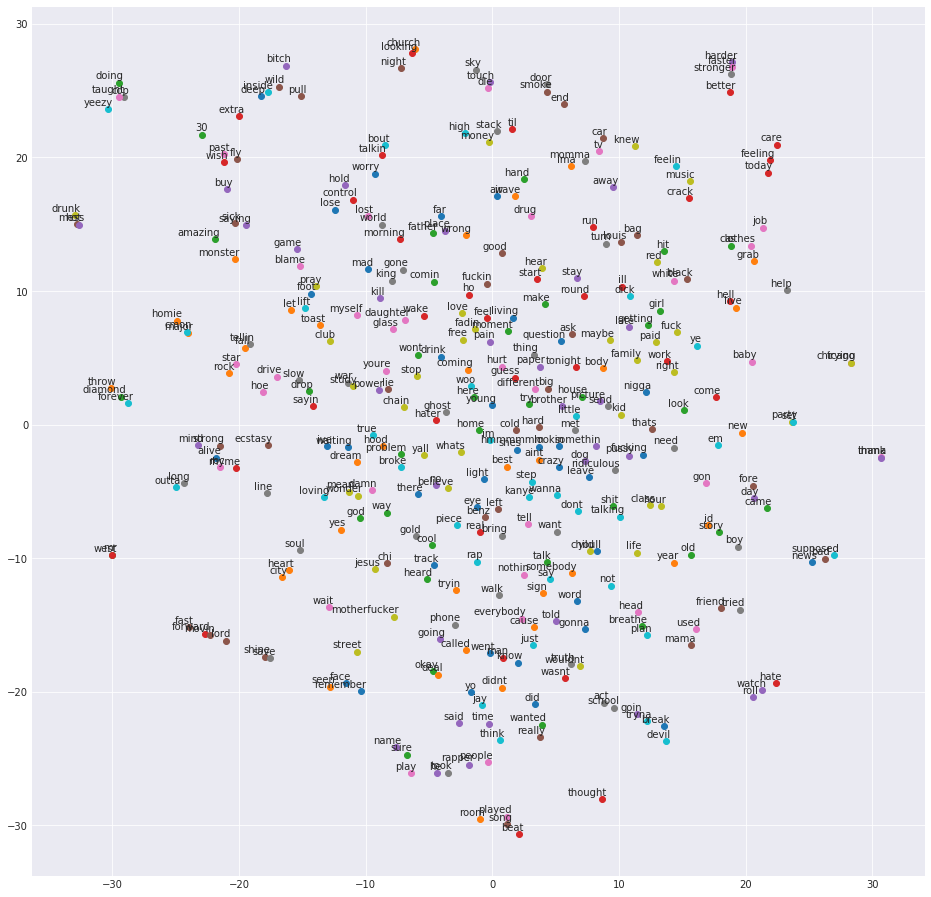

In [3919]:
tsne_plot(model)

### Takeaways
7-10% of the emotional meaning of a message is conveyed through the words
> Denial of diagnosis is a real thing